In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [4]:
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9196307665781291418, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8736493758709101964
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2156275659355759220
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15749585306
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 130565705373458492
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:18:00.0, compute capability: 6.1"]

In [6]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.nasnet import NASNetLarge, preprocess_input

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline


In [41]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [42]:
output_classes = 2
batch_size = 8
img_height, img_width = 331, 331
input_shape = (img_height, img_width, 3)
epochs = 20

nb_train_samples = 59168
nb_validation_samples = 18384
nb_test_samples = 967

In [43]:
train_dir = '/home/peeyush/Radhakrishnan/data/train'
validation_dir = '/home/peeyush/Radhakrishnan/data/validation'
test_dir = '/home/peeyush/Radhakrishnan/data/test'

In [44]:
# if K.image_data_format() == 'channels_first':
#     input_shape = (3, img_width, img_height)
# else:
#     input_shape = (img_width, img_height, 3)

In [45]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

/home/peeyush/Radhakrishnan/data/train 0
/home/peeyush/Radhakrishnan/data/train/malignant 40425
/home/peeyush/Radhakrishnan/data/train/normal 18747
******************************
/home/peeyush/Radhakrishnan/data/validation 0
/home/peeyush/Radhakrishnan/data/validation/malignant 12512
/home/peeyush/Radhakrishnan/data/validation/normal 5872
******************************
/home/peeyush/Radhakrishnan/data/test 0
/home/peeyush/Radhakrishnan/data/test/malignant 655
/home/peeyush/Radhakrishnan/data/test/normal 312


In [46]:
!pwd

/home/peeyush/Radhakrishnan/Task


In [47]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    preprocessing_function = preprocess_input,
    featurewise_std_normalization=True,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255,
                                featurewise_center=True,
                                preprocessing_function = preprocess_input,
                                featurewise_std_normalization=True,
                                zoom_range=0.2,
                                shear_range=0.2)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')


Found 59170 images belonging to 2 classes.
Found 18384 images belonging to 2 classes.
Found 967 images belonging to 2 classes.


In [48]:
# checkpoint
filepath="BIN/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, mode='max', period=3)
callbacks_list = [checkpoint]

In [14]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation="softmax")(x)

model = Model(inputs=base_model.input,outputs=prediction)

In [16]:
# sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
#sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
#rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
# eve_opt = Eve(lr=1e-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [ ]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  callbacks=callbacks_list,
  validation_data = validation_generator,
  validation_steps = nb_validation_samples // batch_size)

Epoch 1/20


In [18]:
plt.style.use("ggplot")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

NameError: name 'history' is not defined

In [15]:
model = tf.keras.models.load_model('/home/peeyush/Radhakrishnan/Task/BIN/weights-improvement-09-0.94.hdf5')

In [49]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

  ...
    to  
  ['...']
Validation Score:  0.2012569964278373
Validation Accuracy:  0.93


In [50]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())


predicts = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

121/120 [==============================] - 27s 219ms/step
No of errors = 30/967


In [51]:
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

preds = model.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=2)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

121/120 [==============================] - 26s 218ms/step
Accuracy 0.9576008273009308


Confusion Matrix
[[618  37]
 [  1 311]]


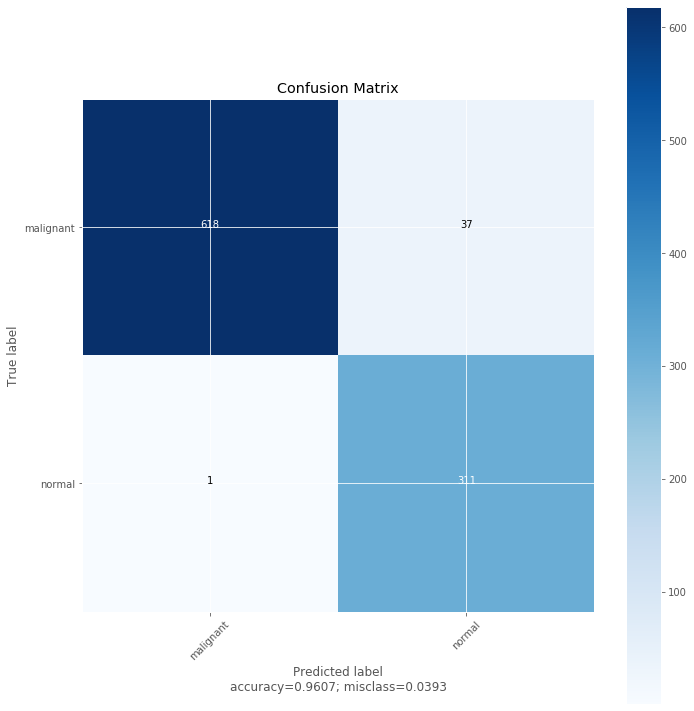

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [59]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[625  30]
 [  0 312]]
              precision    recall  f1-score   support

   malignant       1.00      0.95      0.98       655
      normal       0.91      1.00      0.95       312

    accuracy                           0.97       967
   macro avg       0.96      0.98      0.97       967
weighted avg       0.97      0.97      0.97       967



Confusion Matrix
[[625  30]
 [  0 312]]


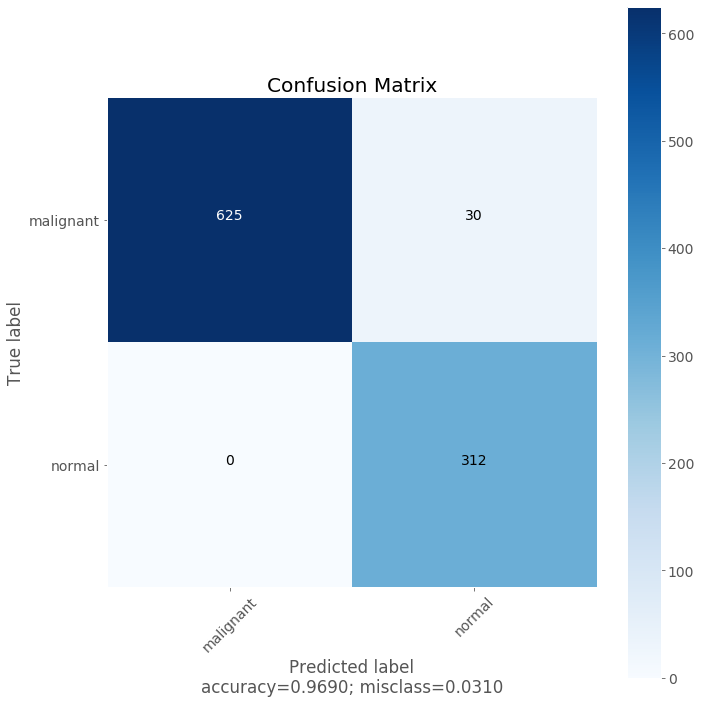

In [66]:


labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(confusion_mtx) / float(np.sum(confusion_mtx))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh =confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, format(confusion_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confusion_mtx[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(confusion_mtx, classes=labels,
                      title='Confusion Matrix')

In [56]:
total=sum(sum(cm))

accuracy = (confusion_mtx[0,0]+confusion_mtx[1,1]) / total
print ('Accuracy : ', accuracy*100)

sensitivity = confusion_mtx[0,0]/(confusion_mtx[0,0]+confusion_mtx[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = confusion_mtx[1,1]/(confusion_mtx[1,1]+confusion_mtx[0,1])
print('Specificity : ', Specificity*100 )

Accuracy :  96.89762150982419
Sensitivity :  100.0
Specificity :  91.22807017543859


In [64]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc*100))
print('Precision: {:.4f}'.format(prec*100))
print('Recall:    {:.4f}'.format(recall*100))
print('F1:        {:.4f}'.format(f1*100))

Accuracy:  96.8976
Precision: 91.2281
Recall:    100.0000
F1:        95.4128


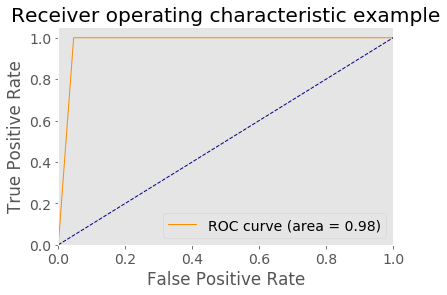

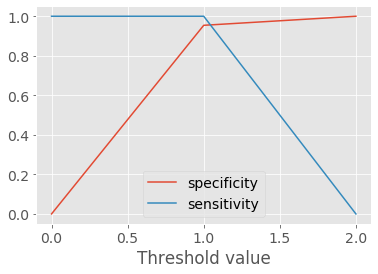

In [65]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 14})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [25]:
model.save('models/5.NASNetLarge-new-ISBI19-Model.h5')
model.save_weights('models/5.NASNetLarge-new-ISBI19-Weights.h5')